In [1]:
import base64
from IPython.display import HTML
import json
import pandas as pd
import sys
import time
import datetime
from IPython.display import Markdown
import matplotlib.pyplot as plt

In [2]:
numOfBatches=4

In [3]:
def durationWithUnit(counter, timeOrCount, type):
    durationWithUnit=str(timeOrCount)
    if batches[counter]['Tests']['type']=='duration':
        return durationWithUnit+ ' sec'
    else:
        return durationSingleTest + ' requests'

In [4]:
def create_download_link( df, title = "Download CSV file", filename = "data.csv"):
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

In [5]:
def addCommonData(resultData):
    resultData['Deployment']=deployment
    resultData['Total CPUs']=totalCPUs
    resultData['Total Memory GB']=totalMemoryGB
    resultData['Duration Single Test']=durationSingleTest
    resultData['Persistence']=persistence
    resultData['App Process URL']=appProcessUrl

In [6]:
counter=1
batches=[]
while counter <= numOfBatches:
    batches.append(json.load(open('test-run'+str(counter)+'/batch.json')))
    #print(batches[counter-1])
    counter=counter+1

In [7]:
counter=0
sysDatas=[]
localHosts=['LOCAL','VM1','VM2']
while counter < numOfBatches:
    systemDataName='test-run'+str(counter+1)+'/results/system-data.csv'
    systemData = pd.read_csv(systemDataName, names=['javaversion', 'totalCPUs', 'totalMemoryGB'],header=0, index_col=False)
    sysData={}
    sysData['jdkVersion']=systemData.javaversion[0]
    sysData['totalCPUs']=systemData.totalCPUs[0]
    sysData['totalMemoryGB']=systemData.totalMemoryGB[0]
    sysData['appVersion']=batches[counter]['InfraSetup']['appVersion']
    sysData['tester']=batches[counter]['InfraSetup']['tester']
    sysData['app']=batches[counter]['InfraSetup']['app']
    sysData['testEngine']=batches[counter]['InfraSetup']['testClient']
    sysData['deployment']='On-premise' if (sysData['tester']['name'] in localHosts and sysData['app']['name'] in localHosts) else 'Cloud'
    appProcess=batches[counter]['Process']
    appProcessUrl=appProcess['schema']+"://"+appProcess['url']+':'+str(appProcess['port'])+'/'+appProcess['app']
    sysData['appProcessUrl']=appProcessUrl
    appInfra=batches[counter]['AppInfra']
    persistence='Mongo' if appInfra['Mongo']=='yes' else 'PostgresQL' if appInfra['PostgresQL']=='yes' else 'None'
    sysData['persistence']=persistence

    sysDatas.append(sysData)
    counter=counter+1
    #print(sysData)


In [8]:
counter=0
testConfigs=[]
while counter < numOfBatches:
    testConfig={}
    testConfig['durationSingleTest']=durationWithUnit(counter, batches[counter]['Tests']['timeOrCount'], batches[counter]['Tests']['type'])
    testConfig['warmup']='no' if batches[counter]['Warmup']=="no" else durationWithUnit(counter, batches[counter]['Warmup']['timeOrCount'], batches[counter]['Warmup']['type'])

    testConfigs.append(testConfig)
    counter=counter+1
    # print(testConfig)


{'durationSingleTest': '120 sec', 'warmup': '60 sec'}
{'durationSingleTest': '120 sec', 'warmup': '60 sec'}
{'durationSingleTest': '120 sec', 'warmup': '60 sec'}
{'durationSingleTest': '120 sec', 'warmup': '60 sec'}


In [9]:
counter=0
testRun=0
testResults=[]
minTimestamp=sys.maxsize
maxTimestamp=0
while counter < numOfBatches:
    testRun=0
    for test in batches[counter]['Tests']['runs']:
        csvName='test-run'+str(counter+1)+'/results/res'+str(testRun)+'.csv'
        result = pd.read_csv(csvName, header=0, index_col=False)
        # print(result)
        resultData={}
        resultData['persistence']=sysDatas[counter]['persistence']
        resultData['appVersion']=sysDatas[counter]['appVersion']
        resultData['persistence-appVersion']=sysDatas[counter]['persistence']+'-'+sysDatas[counter]['appVersion']
        #addCommonData(resultData)
        resultData['#Replicas']=test['replicas']
        resultData['#Users']=test['users']
        resultData['MRT(ms)']=result.Average[0]
        resultData['RPS']=result.Throughput[0]
        # print(resultData)

        usageName='test-run'+str(counter+1)+'/results/usage'+str(testRun)+'.csv'
        usage = pd.read_csv(usageName, 
            names=['appCpuUsage', 'systemCpuUsage', 'appMemoryUsage', 'appMemoryUsagePercentage', 'systemMemoryUsage', 'systemMemoryUsagePercentage'],
            header=0, index_col=False)
        resultData['CPU Usage-app']=usage.appCpuUsage[0]
        resultData['CPU Usage-system']=usage.systemCpuUsage[0]
        resultData['Memory Usage-app']=usage.appMemoryUsage[0]
        resultData['Memory Usage%-app']=usage.appMemoryUsagePercentage[0]
        resultData['Memory Usage-system']=usage.systemMemoryUsage[0]
        resultData['Memory Usage%-system']=usage.systemMemoryUsagePercentage[0]
        # print(resultData)

        testResults.append(resultData)

        jtlName='test-run'+str(counter+1)+'/results/res'+str(testRun)+'.jtl'
        jtl = pd.read_csv(jtlName, header=0, index_col=False)
        minTimestamp=min([minTimestamp, jtl.timeStamp[0]])
        maxTimestamp=max([maxTimestamp, jtl.timeStamp[len(jtl)-1]])

        testRun=testRun+1
    counter=counter+1

# print(testResults)

In [32]:
startTime=time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(minTimestamp/1000))
endTime=time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(maxTimestamp/1000))
batchDuration=str(datetime.timedelta(seconds=(maxTimestamp/1000-minTimestamp/1000)))

counter=0
aggPersistenceVersion='* Persistence | Kogito version combinations:'
while counter < numOfBatches:
    aggPersistenceVersion+='\n - '+sysDatas[counter]['persistence'] + ' | ' + sysDatas[counter]['appVersion']
    counter=counter+1
# print(aggPersistenceVersion)

* Persistence | Kogito version combinations:
-     [Mongo | main] 
-     [Mongo | CoreFix-mem-idx-2.0.0-snap] 
-     [PostgresQL | main] 
-     [PostgresQL | CoreFix-mem-idx-2.0.0-snap] 


In [11]:
Markdown("""
# Kogito Benchmark Multiple Batch Runs
## Test Environment
* Deployment:  {deployment}
* Duration of each test: {durationSingleTest}
* Warmup: {warmup}
* Process: {appProcessUrl}
{aggPersistenceVersionOut}

""".format(deployment=sysDatas[0]['deployment'],aggPersistenceVersionOut=aggPersistenceVersion,
durationSingleTest=testConfigs[0]['durationSingleTest'],warmup=testConfigs[0]['warmup'],appProcessUrl=sysDatas[0]['appProcessUrl']))




# Kogito Benchmark Multiple Batch Runs
## Test Environment
* Deployment:  On-premise
* Duration of each test: 120 sec
* Warmup: 60 sec
* Process: http://appeng-vm02.cloud.lab.eng.bos.redhat.com:8080/simpleHT
* Persistence | Kogito version combinations:</br>- Mongo | main</br>- Mongo | CoreFix-mem-idx-2.0.0-snap</br>- PostgresQL | main</br>- PostgresQL | CoreFix-mem-idx-2.0.0-snap



In [12]:
Markdown("""
## Test Client
* Client host: {hostname}
* Test engine:  {testEngine}
""".format(hostname=sysDatas[0]['tester']['hostname'],testEngine=sysDatas[0]['testEngine']))



## Test Client
* Client host: appeng-vm01.cloud.lab.eng.bos.redhat.com
* Test engine:  JMETER


In [13]:
Markdown("""
## Test Service
* Service host: {hostname} ({totalCPUs} CPU cores, {totalMemoryGB} GB Memory)
* JDK version:  {jdkVersion}
{aggPersistenceVersionOut}
""".format(hostname=sysDatas[0]['app']['hostname'],totalCPUs=sysDatas[0]['totalCPUs'],totalMemoryGB=sysDatas[0]['totalMemoryGB'],
jdkVersion=sysDatas[0]['jdkVersion'],aggPersistenceVersionOut=aggPersistenceVersion))



## Test Service
* Service host: appeng-vm02.cloud.lab.eng.bos.redhat.com (4 CPU cores, 15.51 GB Memory)
* JDK version:  openjdk version "11.0.12" 2021-07-20 LTS
* Persistence | Kogito version combinations:</br>- Mongo | main</br>- Mongo | CoreFix-mem-idx-2.0.0-snap</br>- PostgresQL | main</br>- PostgresQL | CoreFix-mem-idx-2.0.0-snap


## Execution Report
### Chart view

In [14]:
raw = pd.DataFrame(testResults)
# print(raw)

   persistence                  appVersion  \
0        Mongo                        main   
1        Mongo                        main   
2        Mongo                        main   
3        Mongo                        main   
4        Mongo                        main   
5        Mongo  CoreFix-mem-idx-2.0.0-snap   
6        Mongo  CoreFix-mem-idx-2.0.0-snap   
7        Mongo  CoreFix-mem-idx-2.0.0-snap   
8        Mongo  CoreFix-mem-idx-2.0.0-snap   
9        Mongo  CoreFix-mem-idx-2.0.0-snap   
10  PostgresQL                        main   
11  PostgresQL                        main   
12  PostgresQL                        main   
13  PostgresQL                        main   
14  PostgresQL                        main   
15  PostgresQL  CoreFix-mem-idx-2.0.0-snap   
16  PostgresQL  CoreFix-mem-idx-2.0.0-snap   
17  PostgresQL  CoreFix-mem-idx-2.0.0-snap   
18  PostgresQL  CoreFix-mem-idx-2.0.0-snap   
19  PostgresQL  CoreFix-mem-idx-2.0.0-snap   

                   persistence-ap

In [15]:
# raw.insert(1,'Start Time', startTime)
# raw.insert(2,'End Time', endTime)
# raw.insert(3,'Batch Duration', batchDuration)


In [16]:
users = raw['#Users'].unique()
# print(users)

[  1   4   8  60 100]


In [17]:
counter=0
combinedData = {}
for r in raw['persistence-appVersion'].unique():
    colValues = raw[raw['persistence-appVersion']==r]['MRT(ms)'].values
    combinedData[r] = colValues    

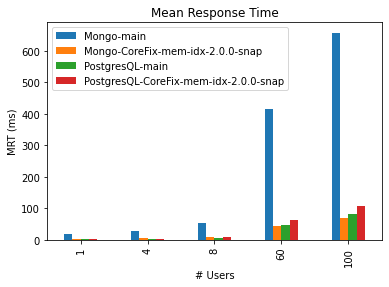

In [18]:
mrtDF = pd.DataFrame(combinedData, index=users)
mrtDF.plot(kind="bar")
plt.title("Mean Response Time")
plt.xlabel("# Users")
plt.ylabel("MRT (ms)")
plt.rcParams["figure.figsize"] = (10,4)


In [19]:
counter=0
combinedData = {}
for r in raw['persistence-appVersion'].unique():
    colValues = raw[raw['persistence-appVersion']==r]['RPS'].values
    combinedData[r] = colValues    

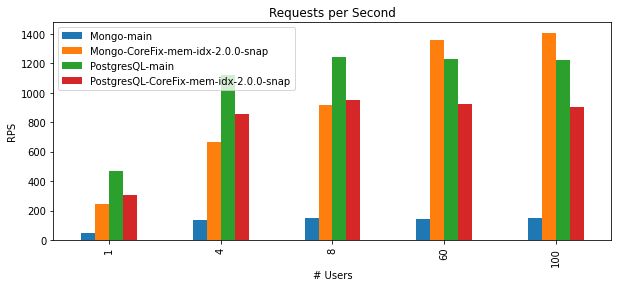

In [20]:
mrtDF = pd.DataFrame(combinedData, index=users)

mrtDF.plot(kind="bar")
plt.title("Requests per Second")
plt.xlabel("# Users")
plt.ylabel("RPS")
plt.rcParams["figure.figsize"] = (10,4)

In [21]:
counter=0
combinedData = {}
for r in raw['persistence-appVersion'].unique():
    colValues = raw[raw['persistence-appVersion']==r]['CPU Usage-app'].str.replace('%','').apply(pd.to_numeric).values
    combinedData[r] = colValues      

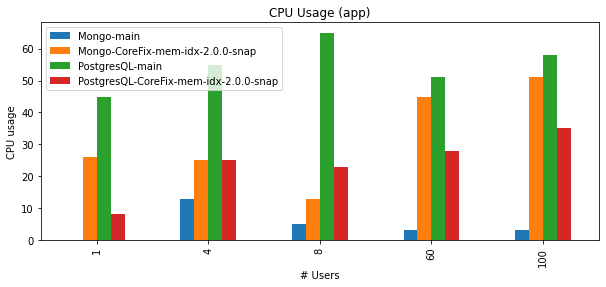

In [22]:
cpusDF = pd.DataFrame(combinedData, index=users)
cpusDF.plot(kind="bar")
plt.title("CPU Usage (app)")
plt.xlabel("# Users")
plt.ylabel("CPU usage")
plt.rcParams["figure.figsize"] = (10,4)

In [23]:
counter=0
combinedData = {}
for r in raw['persistence-appVersion'].unique():
    colValues = raw[raw['persistence-appVersion']==r]['Memory Usage-app'].str.replace('MB','').apply(pd.to_numeric).values
    combinedData[r] = colValues  

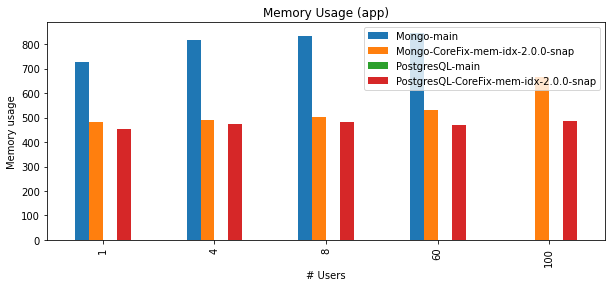

In [24]:
memoryUsageDF = pd.DataFrame(combinedData, index=users)
memoryUsageDF.plot(kind="bar")
plt.title("Memory Usage (app)")
plt.xlabel("# Users")
plt.ylabel("Memory usage")
plt.rcParams["figure.figsize"] = (10,4)

### Tabular view

In [25]:
raw.style.hide_index().hide_columns(['persistence-appVersion'])

persistence,appVersion,#Replicas,#Users,MRT(ms),RPS,CPU Usage-app,CPU Usage-system,Memory Usage-app,Memory Usage%-app,Memory Usage-system,Memory Usage%-system
Mongo,main,1,1,20,49.100000,0%,25.60%,727.98MB,4.58%,1494.00MB,9.40%
Mongo,main,1,4,28,138.100000,13%,85.50%,819.21MB,5.15%,1599.27MB,10.06%
Mongo,main,1,8,54,145.800000,5%,97.90%,835.10MB,5.25%,1614.61MB,10.16%
Mongo,main,1,60,416,142.800000,3%,99.70%,846.98MB,5.33%,1671.70MB,10.52%
Mongo,main,1,100,657,151.000000,3%,99.90%,0MB,0%,1848.12MB,11.63%
Mongo,CoreFix-mem-idx-2.0.0-snap,1,1,3,246.800000,26%,23.70%,482.32MB,3.03%,1385.05MB,8.72%
Mongo,CoreFix-mem-idx-2.0.0-snap,1,4,5,664.800000,25%,57.70%,490.78MB,3.08%,1402.92MB,8.83%
Mongo,CoreFix-mem-idx-2.0.0-snap,1,8,8,916.100000,13%,73.00%,504.51MB,3.17%,1449.69MB,9.12%
Mongo,CoreFix-mem-idx-2.0.0-snap,1,60,43,1359.100000,45%,92.30%,531.10MB,3.34%,1720.19MB,10.83%
Mongo,CoreFix-mem-idx-2.0.0-snap,1,100,70,1408.200000,51%,92.50%,666.03MB,4.19%,1866.91MB,11.75%


In [27]:
# downloadName=(deployment+'_'+startTime+'.csv').replace(':',"_").replace(' ',"_")
# create_download_link(df=raw, filename=downloadName, title='Download detailed CSV report')